In [221]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import math
import copy

import random

In [219]:
rng = np.random.default_rng(1234)

# Algorytm

In [316]:
class AntColony:
    def __init__(self, number_of_ants = None, alpha = 1, beta = 1,
                 starting_pheromone = 1, Q = 1, ro = 0.9):
        if number_of_ants is not None and number_of_ants <= 0:
            raise Exception("Negative number of ants")
        if number_of_ants is not None and number_of_ants != math.floor(number_of_ants):
            raise Exception("Number of ants is not an intefer")
        if alpha < 0:
            raise Exception("Alpha parameter has to be positive")
        if beta < 0:
            raise Exception("Beta parameter has to be positive")
        if starting_pheromone < 0:
            raise Exception("starting_pheromone parameter has to be positive")
        if Q < 0:
            raise Exception("Q parameter has to be positive")
        if ro < 0 or ro > 1:
            raise Exception("ro parameter has to be in [0,1] range")

        self.number_of_ants = number_of_ants
        self.alpha = alpha
        self.beta = beta
        self.starting_pheromone = starting_pheromone
        self.Q = Q
        self.ro = ro
    
    def set_problem(self, coordinates, request, capasity, s_max, number_of_cars):
        if coordinates.shape[1] != 2:
            raise Exception("coordinates are not in IR^2")
        if coordinates.shape[0]-1 != request.shape[0]:
            raise Exception("Different number of coordinates and requests")
        if np.any(request <= 0):
            raise Exception("There is non positive request")
        if np.any(request > capasity):
            raise Exception("There is request bigger than capasity. This problem is unsolvable!")
        if number_of_cars < 0:
            raise Exception("number_of_cars parameter has to be positive")
            
        self.problem_size = coordinates.shape[0]
        self.coordinates = coordinates
        self.request = request
        self.capasity = capasity
        
        self.restart()
        
        if self.number_of_ants is None:
            self.number_of_ants = 2 * self.problem_size
        
        if np.any(self.distance_matrix[0] * 2 > s_max):
            raise Exception("There is distance bigger than max_s / 2. This problem is unsolvable! Check antColony.distance_matrix")

        self.s_max = s_max
        self.number_of_cars = number_of_cars
    
    def restart(self):
        self.pheromone_restart()
        self.calculate_distance_matrix()
        self.calculate_transition_matrix()
        
        self.best_cost = np.inf
        self.best_path = None
        self.best_cycles_number = None
        
    def calculate_distance_matrix(self):
        self.distance_matrix = np.zeros((self.problem_size, self.problem_size))
        
        for i in range(0, self.problem_size):
            for j in range(i+1, self.problem_size): # only above the diagonal
                d = np.linalg.norm( self.coordinates[i,:] - self.coordinates[j,:] )
                self.distance_matrix[i, j] = d
                self.distance_matrix[j, i] = d
    
    def calculate_transition_matrix(self):
        # self.T_P is non standardize Probability
        modified_distance_matrix = self.distance_matrix + np.eye(self.problem_size) # diagonal will later be set to 0
        self.T_P = self.pheromone_matrix**self.alpha*(1/modified_distance_matrix)**self.beta
        np.fill_diagonal(self.T_P, 0)
    
    def pheromone_restart(self):
        self.pheromone_matrix = self.starting_pheromone * (np.ones((self.problem_size,
                                                                    self.problem_size)) - np.eye(self.problem_size))
        
    def ant_find_path(self): # return (list of nodes, number of times to start from warehouse - number of 0 in list of nodes minus 1 - number of ant_find_circle() calls)
        visited_nodes = [0] # start from warehouse
        number_of_cicles = 0
        while len(visited_nodes) - number_of_cicles < self.problem_size: # in visited_nodes should be [0,1,...,self.problem_size] and additionally number_of_cicles zeros
            number_of_cicles += 1
            visited_nodes = self.ant_find_circle(visited_nodes)
        
        return visited_nodes, number_of_cicles
    
    def ant_find_circle(self, visited_nodes):
        if visited_nodes is None or len(visited_nodes) == 0 or visited_nodes[-1] != 0:
            raise Exception("ant is not at the warehouse")
            
        node = 0
        dist_from_warehouse = 0
        capasity_left = self.capasity
        
        # do_while loop
        move = self.ant_make_move(visited_nodes, capasity_left, dist_from_warehouse)
        visited_nodes.append(move)
        dist_from_warehouse += self.distance_matrix[node, move]
        capasity_left -= self.request[move-1] # self.request is indexed from 1, coz 0 is warehouse
        node = move
        while(node != 0):
            move = self.ant_make_move(visited_nodes, capasity_left, dist_from_warehouse)
            visited_nodes.append(move)
            dist_from_warehouse += self.distance_matrix[node, move]
            capasity_left -= self.request[move-1] # self.request is indexed from 1, coz 0 is warehouse
            node = move
        
        return visited_nodes
    
    def ant_make_move(self, visited_nodes, capasity_left, dist_from_warehouse): # wylosuj z rozkladu self.T_P[dopuszczalne]
        node = visited_nodes[-1]
        if node == 0 and dist_from_warehouse != 0:
            raise Exception("ant is in warehouse, but the dist_from_warehouse is not 0")
        if capasity_left < 0:
            raise Exception("There is less than none capasity left")
        
        possible_nodes = self.get_possible_nodes(visited_nodes, capasity_left, dist_from_warehouse)
        
        if len(possible_nodes) == 0:
            raise Exception("There is nowhere to go :(")
        
        
        my_cum_sum = np.cumsum(self.T_P[node][possible_nodes])
        c = my_cum_sum[-1]
        
        u = self.rng.uniform() * c
        
        return possible_nodes[np.where(u < my_cum_sum)[0][0]] # EXP: np.where(u < my_cum_sum) == ([3,4,5],) # so the 3 was drawn
    
    def get_possible_nodes(self, visited_nodes, capasity_left, dist_from_warehouse):
        node = visited_nodes[-1]
        
        possible_nodes = [i for i in range(1, self.problem_size)] # 0 bedzie dodane pozniej
        
        for i in visited_nodes:
            if i != 0:
                possible_nodes.remove(i)
        
        possible_nodes_copy = copy.copy(possible_nodes) # boz kopii tez bedzie usuwal, ale potem nie sprawdzi nastepnego za pominietym
        for i in possible_nodes_copy:
            if capasity_left < self.request[i-1]:
                possible_nodes.remove(i)
        
        possible_nodes_copy = copy.copy(possible_nodes)
        for i in possible_nodes_copy:
            if dist_from_warehouse + self.distance_matrix[node, i] + self.distance_matrix[i, 0] > self.s_max:
                possible_nodes.remove(i)
            
        if node != 0:
            possible_nodes.append(0)
        
        return possible_nodes
    
    def calculate_cost(self, path):
        cost_sum = 0
        for i in range(len(path)-1):
            cost_sum += self.distance_matrix[path[i],path[i+1]]
        return cost_sum
    
    def pheromone_modify(self, paths):
        self.pheromone_matrix *= (1-self.ro)
        delta_pheromone_matrix = np.zeros_like(self.pheromone_matrix)
        for path in paths:
            # path = [0,4,3,0,1,5,2,0]
            for i in range(len(path)-1):
                delta_pheromone_matrix[path[i], path[i+1]] += 1/self.distance_matrix[path[i], path[i+1]]
        self.pheromone_matrix += self.Q * delta_pheromone_matrix
    
    def single_iteration(self, print_progres, iteration):
        paths = [None for i in range(self.number_of_ants)]
        num_of_cycles = [None for i in range(self.number_of_ants)]
        for i in range(self.number_of_ants):
            paths[i], num_of_cycles[i] = self.ant_find_path()
        costs = np.array([self.calculate_cost(paths[i]) for i in range(self.number_of_ants)])
        
        i_min_cost = np.argmin(costs)
        if costs[i_min_cost] < self.best_cost:
            self.best_path = paths[i_min_cost]
            self.best_cost = costs[i_min_cost]
            self.best_cycles_number = num_of_cycles[i_min_cost]
            if print_progres:
                print("New best solution in {} iteration: cost = {:.2f} and uses {} trucks".format(iteration, self.best_cost, self.best_cycles_number))
        
        self.pheromone_modify(paths)
    
    def optimize(self, max_iter, print_progres = False, rng_seed = None, new = True):
        self.rng = np.random.default_rng(rng_seed)
        if new:
            self.restart()
        for i in range(max_iter):
            self.single_iteration(print_progres, i)
        
        # TODO - Czy udało się znaleść rozwiązanie z dobrą liczbą samochodów?

# Definicja problemu

In [373]:
rng.choice([1,3,2], 2)

array([2, 2])

In [420]:
M = 100

G=nx.Graph()
G.add_edges_from([(0, j) for j in range(1, M)])

edges = [(i, j) for i in range(M) for j in range(M) if i != j]
edges = rng.choice(edges, 50)
G.add_edges_from(edges)

edges = [(i, j) for i in range(1, int(M/2)) for j in range(1, int(M/2)) if i != j]
edges = rng.choice(edges, 300)
G.add_edges_from(edges)

edges = [(i, j) for i in range(int(M/2), M) for j in range(int(M/2), M) if i != j]
edges = rng.choice(edges, 300)
G.add_edges_from(edges)

In [421]:
pos = nx.spring_layout(G)

In [422]:
P = list((M) * ["red"])
P[0] = "blue"

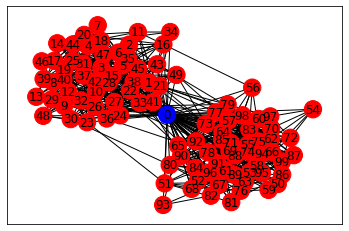

In [423]:
fig1 = nx.draw_networkx(G, pos = pos, node_color=P)

# Przygotowanie do plotowania

In [424]:
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(M)]

In [425]:
def plot_solution(antColony):
    i = 0
    for node in antColony.best_path:
        if node == 0:
            i += 1
        else:
            P[node] = color[i-1]

    G=nx.Graph()
    G.add_edges_from([(i, j) for i in range(M) for j in range(M) if i != j])

    fig1 = nx.draw_networkx(G, pos = pos, node_color=P,
                            edgelist = [(antColony.best_path[i], antColony.best_path[i+1]) for i in range(len(antColony.best_path)-1)])

# Rozwiązanie

In [450]:
antColony = AntColony(number_of_ants=None, alpha=1, beta=5, starting_pheromone = 1, Q = 1)

coordinates = np.empty((M,2))
for i in range(M):
    coordinates[i] = pos[i]

request = np.ones(M-1) * 10

antColony.set_problem(coordinates, request, 110, 1000, 5)

In [451]:
antColony.optimize(10, print_progres=True)

New best solution in 0 iteration: cost = 26.14 and uses 10 trucks
New best solution in 2 iteration: cost = 25.72 and uses 10 trucks
New best solution in 6 iteration: cost = 25.65 and uses 10 trucks


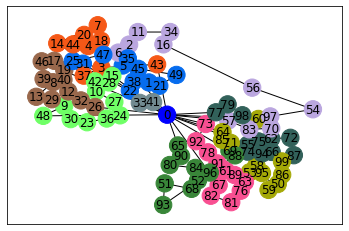

In [452]:
plot_solution(antColony)

In [453]:
antColony.beta /= 2
antColony.optimize(10, print_progres=True, new=False)

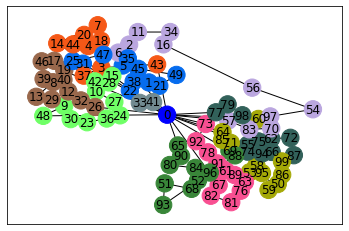

In [454]:
plot_solution(antColony)

In [455]:
antColony.beta /= 2
antColony.optimize(10, print_progres=True, new=False)

New best solution in 6 iteration: cost = 25.13 and uses 9 trucks


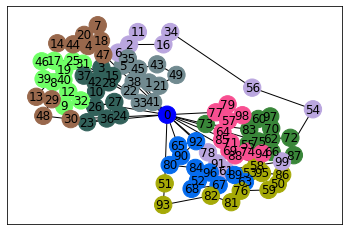

In [456]:
plot_solution(antColony)

In [457]:
antColony.beta /= 2
antColony.optimize(10, print_progres=True, new=False)

New best solution in 0 iteration: cost = 24.95 and uses 10 trucks


KeyboardInterrupt: 

In [ ]:
plot_solution(antColony)

In [ ]:
antColony.beta /= 2
antColony.optimize(10, print_progres=True, new=False)

In [ ]:
plot_solution(antColony)

In [ ]:
antColony.beta /= 2
antColony.optimize(10, print_progres=True, new=False)

In [ ]:
plot_solution(antColony)